In [1]:
import os
import h5py
import pandas as pd
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from random import randint
from random import shuffle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
plt.ion()   # interactive mode

/opt/applications/python/3.6.3/gnu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Create new datasets

In [2]:
PATH = "datasets/"
trainHdf5 = f'{PATH}Chong_train_set.hdf5'
traindata = h5py.File(trainHdf5, 'r')
valHdf5 = f'{PATH}Chong_valid_set.hdf5'
valdata = h5py.File(valHdf5, 'r')
testHdf5 = f'{PATH}Chong_test_set.hdf5'
testdata = h5py.File(testHdf5, 'r')

In [3]:
vallabel = valdata['label_names'][()]

In [6]:
vallabelde = vallabel.astype(str, copy=False)

In [7]:
valimg = valdata['data1'][()]

In [8]:
delin = np.where(vallabelde == 'PEROXISOME')

In [9]:
vallabel_n = np.delete(vallabel, delin)

In [10]:
valimg_n = np.delete(valimg, delin,0)

In [13]:
valdata2.close()

In [14]:
val2Hdf5 = f'{PATH}Chong_valid_set_new.hdf5'
valdata2 = h5py.File(val2Hdf5, 'w')
valdata2.create_dataset('data1', data=valimg_n, dtype='float32')
valdata2.create_dataset('label_names', data=vallabel_n)

<HDF5 dataset "label_names": shape (4368,), type "|S16">

## Data loading

In [2]:
PATH = "datasets/"
trainHdf5 = f'{PATH}Chong_train_set_new.hdf5'
traindata = h5py.File(trainHdf5, 'r')
valHdf5 = f'{PATH}Chong_valid_set_new.hdf5'
valdata = h5py.File(valHdf5, 'r')
testHdf5 = f'{PATH}Chong_test_set.hdf5'
testdata = h5py.File(testHdf5, 'r')

In [30]:
idx_classes = sorted(list(set([y.decode("utf-8") for y in traindata['label_names']])))
idx_to_class = {idx_classes.index(x):x  for x in idx_classes}

In [32]:
idx_classes2 = sorted(list(set([y.decode("utf-8") for y in traindata['label_names']])))
idx_classes2.append('PEROXISOME')
idx_to_class2 = {idx_classes2.index(x):x  for x in idx_classes2}

In [4]:
class ChongSet(Dataset):
    
    def __init__(self, hdf5, transform=None):
        classes = sorted(list(set([y for y in hdf5['label_names']])))
        class_to_idx = {x: classes.index(x) for x in classes}
        
        imgs = hdf5['data1']
        labels = hdf5['label_names']
        self.transform = transform
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.imgs = imgs
        self.labels = labels
        self.data = []
        
        for i in range(len(imgs)):
            tmp = (np.array(imgs[i,:]).reshape(2,64,64).T, labels[i])
            self.data.append(tmp)
  
        
    def __len__(self):
        return(self.imgs.shape[0])
    
    def __getitem__(self, idx):
               
        img, cls = self.data[idx]
        cls = self.class_to_idx[cls]

        if self.transform:
            img = self.transform(img)
       
        return(img, cls)

In [73]:
class ChongSet2(Dataset):
    
    def __init__(self, hdf5, transform=None):
        classes = [x.encode() for x in idx_classes2]
        class_to_idx = {x: classes.index(x) for x in classes}
        imgs = hdf5['data1']
        labels = hdf5['label_names']
        self.transform = transform
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.imgs = imgs
        self.labels = labels
        self.data = []
        
        for i in range(len(imgs)):
            tmp = (np.array(imgs[i,:]).reshape(2,64,64).T, labels[i])
            self.data.append(tmp)
  
        
    def __len__(self):
        return(self.imgs.shape[0])
    
    def __getitem__(self, idx):
               
        img, cls = self.data[idx]
        cls = self.class_to_idx[cls]

        if self.transform:
            img = self.transform(img)
       
        return(img, cls)

In [5]:
def randomsequence():
    
    class RandomCrop(object):
        """Crop randomly the image in a sample.

        Args:
            output_size (tuple or int): Desired output size. If int, square crop
                is made.
        """

        def __init__(self, output_size):
            assert isinstance(output_size, (int, tuple))
            if isinstance(output_size, int):
                self.output_size = (output_size, output_size)
            else:
                assert len(output_size) == 2
                self.output_size = output_size

        def __call__(self, sample):
            image= sample

            h, w = image.shape[:2]
            new_h, new_w = self.output_size

            top = np.random.randint(0, h - new_h)
            left = np.random.randint(0, w - new_w)

            image = image[top: top + new_h,
                          left: left + new_w]

            return image


    class FlipLeftRight(object):

        def __call__(self, sample):
            image= sample
            #h,w,c = image.shape
            if random.random() < 0.5:
                return(np.flip(image, 0).copy())
            else:
                return(image)

    class UpLeftDown(object):

        def __call__(self, sample):
            image= sample
            #h,w,c = image.shape
            if random.random() < 0.5:
                return(np.flip(image, 1).copy())
            else:
                return(image)

    class RandomRotate(object):

        def __call__(self, sample):
            image = sample
            u = randint(0,3)
            return(np.rot90(image, u, (0,1)).copy())

    class RandomMultiply(object):
        def __init__(self, low, high):
            self.multiply = random.uniform(low, high)
        def __call__(self, sample):
            image=sample
            return(np.multiply(image, self.multiply).copy())
    
    
    functions = list([RandomCrop(60),
        FlipLeftRight(),
        UpLeftDown(),
        RandomRotate(),
        RandomMultiply(0.8, 1.2)]),
    shuffle(functions)
    functions = functions[0]
    functions.append(transforms.ToTensor())
    functions.append(transforms.Normalize([0.5,0.5],[0.5,0.5]))
    return(functions)

In [6]:
data_transforms = {
    'train': transforms.Compose(randomsequence()),
    'val':transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5], [0.5, 0.5])
    ]),
    'test':transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5], [0.5, 0.5])
    ]),
}

In [74]:
image_datasets = {'train': ChongSet(traindata, transform = data_transforms['train'] ), 'val': ChongSet(valdata, transform = data_transforms['val']), 'test': ChongSet2(testdata, transform = data_transforms['test'])}
image_datasets

{'test': <__main__.ChongSet2 at 0x7fafd6c1b128>,
 'train': <__main__.ChongSet at 0x7fafd6c306d8>,
 'val': <__main__.ChongSet at 0x7fafd7c93ac8>}

In [75]:
dataloaders = {'train':torch.utils.data.DataLoader(image_datasets['train'], batch_size=128, shuffle=True, num_workers=4),
               'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=16, shuffle=False, num_workers=4),
               'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=16, shuffle=False,num_workers=4)}
dataloaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7faf53229b00>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7faf532299b0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7faf53229a58>}

In [10]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
dataset_sizes

{'test': 4516, 'train': 20894, 'val': 4368}

In [11]:
use_gpu = torch.cuda.is_available()
use_gpu

True

## Load model

In [12]:
class Deeploc(nn.Module):
    def __init__(self):
        super(Deeploc, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(2, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding =1),
            nn.Dropout2d(p=0.2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2, padding = 1)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding =1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding = 1),
            nn.Dropout2d(p=0.2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding = 1)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.Dropout2d(p=0.2),
            nn.BatchNorm2d(256),
            nn.ReLU() 
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.conv8 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.Dropout2d(p=0.2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(8*8*256, 512),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.logit = nn.Linear(512, 19)

        
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = x.view(-1, 8*8*256)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.logit(x)
        
        return F.sigmoid(x)

In [13]:
model = Deeploc()

In [14]:
model.load_state_dict(torch.load('DeepLocML6.pth'))

In [15]:
num_ftrs = model.logit.in_features
model.logit = nn.Linear(num_ftrs, 18)

In [28]:
num_ftrs

512

In [29]:
model

Deeploc(
  (conv1): Sequential(
    (0): Conv2d (2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Dropout2d(p=0.2)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  )
  (conv3): Sequential(
    (0): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Dropout2d(p=0.2)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  )
  (conv5): Sequential(
    (0): C

## Train and validate functions

In [16]:
def get_multilabel_accuracy(pred, target):
    pred = pred > 0.4
    comp = torch.sum(torch.abs(pred.long() - target.long()).long(), dim=1)
    acc = pred.size()[0] - len(torch.nonzero(comp))
    return(acc/(pred.size()[0]))

In [17]:
def get_element_accuracy(pred, target):
    pred = pred > 0.4
    r = (pred == target.byte())
    acc = r.float().cpu().sum().data[0]
    return acc/(pred.size()[1]*pred.size()[0])

In [18]:
def train(model, loader, criterion, optimizer, scheduler, verbose=False):
    #scheduler.step()
    model.train()
    running_loss=0
    running_accuracy=0
    element_accuracy =0
    for i, (X, y) in enumerate(loader):
        y = torch.from_numpy(np.eye(18)[y]).float()
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        loss = 50*criterion(output, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0]
        acc = get_multilabel_accuracy(output, y)
        acce = get_element_accuracy(output, y)
        running_accuracy += acc
        element_accuracy += acce
        if i%400 == 0 and verbose:
            pct = float(i+1)/len(loader)
            curr_loss = running_loss/(i+1)
            curr_acc = running_accuracy/(i+1)
            print('Complete:{:.2f}, loss:{:.2f}, Accuracy:{:.4f}'.format(pct*100, curr_loss, curr_acc))
    return(running_loss/len(loader),element_accuracy/len(loader),running_accuracy/len(loader))

In [19]:
def validate(model, loader, criterion):
    model.eval()
    running_loss = 0
    running_accuracy = 0
    element_accuracy =0
    targets = torch.FloatTensor(0, 18)
    predictions = torch.FloatTensor(0, 18)
    for i, (X, y) in enumerate(loader):
        y = torch.from_numpy(np.eye(18)[y]).float()
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X, volatile=True), Variable(y)
        output = model(X)
        loss = 50*criterion(output, y)
        acc = get_multilabel_accuracy(output, y)
        acce = get_element_accuracy(output, y)
        targets = torch.cat((targets, y.cpu().data), 0)
        predictions = torch.cat((predictions, output.cpu().data), 0)
        running_loss += loss.data[0]
        running_accuracy += acc
        element_accuracy += acce
    fscore = fbeta_score(targets.numpy(), predictions.numpy() > 0.4, beta=2, average = 'samples')
    return(running_loss/len(loader), element_accuracy/len(loader), running_accuracy/len(loader), fscore)
    

In [20]:
criterion = torch.nn.BCELoss()
if use_gpu:
    model, criterion = model.cuda(), criterion.cuda()

In [21]:
patience = 5
best_loss = 1e4

In [22]:
optimizer = optim.Adam(model.logit.parameters(), lr = 0.05)
#optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
#scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

In [23]:
from sklearn.metrics import fbeta_score

In [24]:
for e in range(100):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    start = time.time()
    train_loss, train_acce,train_acc = train(model, dataloaders['train'], criterion, optimizer, scheduler, verbose = False)
    val_loss, val_acce, val_acc, fscore = validate(model, dataloaders['val'], criterion)
    scheduler.step(val_loss)
    end = time.time()
    
    stats = """Epoch: {}\t train loss: {:.3f}, train acc: {:.3f}, actual acc: {:.3f}\t
                val loss: {:.3f}, val acc: {:.3f}, actual acc: {:.3f}\t fscore: {:.3f}\t
                time: {:.1f}s""".format( e, train_loss, train_acce, train_acc, val_loss, val_acce, val_acc, fscore, end-start)
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    print(stats)

Epoch: 0	 train loss: 1.752, train acc: 0.986, actual acc: 0.876	
                val loss: 0.853, val acc: 0.994, actual acc: 0.930	 fscore: 0.949	
                time: 44.5s


/opt/applications/python/3.6.3/gnu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


Epoch: 1	 train loss: 0.495, train acc: 0.997, actual acc: 0.963	
                val loss: 0.836, val acc: 0.995, actual acc: 0.935	 fscore: 0.950	
                time: 43.7s
Epoch: 2	 train loss: 0.413, train acc: 0.997, actual acc: 0.966	
                val loss: 0.803, val acc: 0.995, actual acc: 0.938	 fscore: 0.954	
                time: 43.7s
Epoch: 3	 train loss: 0.368, train acc: 0.997, actual acc: 0.966	
                val loss: 0.863, val acc: 0.995, actual acc: 0.937	 fscore: 0.951	
                time: 43.7s
Epoch: 4	 train loss: 0.350, train acc: 0.998, actual acc: 0.967	
                val loss: 0.879, val acc: 0.995, actual acc: 0.939	 fscore: 0.955	
                time: 43.7s
Epoch: 5	 train loss: 0.345, train acc: 0.998, actual acc: 0.968	
                val loss: 0.872, val acc: 0.995, actual acc: 0.940	 fscore: 0.955	
                time: 43.7s
Epoch: 6	 train loss: 0.336, train acc: 0.997, actual acc: 0.967	
                val loss: 0.868, val acc: 0.995, 

Epoch: 48	 train loss: 0.300, train acc: 0.998, actual acc: 0.972	
                val loss: 0.898, val acc: 0.995, actual acc: 0.944	 fscore: 0.955	
                time: 43.8s
Epoch: 49	 train loss: 0.311, train acc: 0.998, actual acc: 0.973	
                val loss: 0.893, val acc: 0.995, actual acc: 0.945	 fscore: 0.955	
                time: 43.8s
Epoch: 50	 train loss: 0.290, train acc: 0.998, actual acc: 0.973	
                val loss: 0.891, val acc: 0.995, actual acc: 0.943	 fscore: 0.956	
                time: 43.8s
Epoch: 51	 train loss: 0.292, train acc: 0.998, actual acc: 0.973	
                val loss: 0.883, val acc: 0.995, actual acc: 0.943	 fscore: 0.954	
                time: 43.8s
Epoch: 52	 train loss: 0.301, train acc: 0.998, actual acc: 0.971	
                val loss: 0.871, val acc: 0.995, actual acc: 0.944	 fscore: 0.956	
                time: 43.9s
Epoch: 53	 train loss: 0.295, train acc: 0.998, actual acc: 0.973	
                val loss: 0.870, val acc: 0

Epoch: 95	 train loss: 0.292, train acc: 0.998, actual acc: 0.972	
                val loss: 0.890, val acc: 0.995, actual acc: 0.943	 fscore: 0.954	
                time: 43.8s
Epoch: 96	 train loss: 0.305, train acc: 0.998, actual acc: 0.973	
                val loss: 0.887, val acc: 0.995, actual acc: 0.944	 fscore: 0.954	
                time: 43.8s
Epoch: 97	 train loss: 0.319, train acc: 0.998, actual acc: 0.970	
                val loss: 0.871, val acc: 0.995, actual acc: 0.943	 fscore: 0.955	
                time: 43.9s
Epoch: 98	 train loss: 0.292, train acc: 0.998, actual acc: 0.973	
                val loss: 0.897, val acc: 0.995, actual acc: 0.944	 fscore: 0.955	
                time: 43.8s
Epoch: 99	 train loss: 0.288, train acc: 0.998, actual acc: 0.972	
                val loss: 0.851, val acc: 0.995, actual acc: 0.945	 fscore: 0.957	
                time: 43.7s


In [26]:
torch.save(model.state_dict(), 'DeepLocML7_18.pth')

## Test data

In [39]:
def duplicate(i_pred):
    from collections import Counter
    return([item for item, count in Counter(i_pred).items() if count > 1])

In [40]:
def missing(L, start, end):
    return sorted(set(range(start, end)).difference(L))

In [42]:
def compare(i_pred, j_pred, end):

    pred_n = np.zeros((end))
    #missing
    miss_items = missing(i_pred, 0, end)
    # duplicate
    dup_items = duplicate(i_pred)
    for i in list(range(0,end)):
        if i in miss_items:
            pred_n[i] = 20
        elif i in dup_items:
            pred_n[i] = 21
        else:
            t, = np.where(i_pred==i)
            pred_n[i] = j_pred[t[0]]
    return(pred_n)

In [79]:
def pred_analysis(dataset, actual, predict):
    for i, (X, y) in enumerate(dataset):
        if use_gpu:
            X= X.cuda()
        X = Variable(X)
        outputs = model(X)
        outputs = outputs.cpu()
        #y2 = torch.from_numpy(np.eye(19)[y]).float()
        #y2 = Variable(y2)
        #acc = get_multilabel_accuracy(outputs, y2)
        preds = outputs>0.4
        #preds= preds.data.numpy()
        y = y.numpy()  
        end = len(y)
        i_pred,j_pred = np.where(preds.data==1)
        pred_n = compare(i_pred, j_pred, end)
        actual = np.append(actual, y)
        predict = np.append(predict, pred_n)
    return(actual, predict)

In [44]:
def calculate_cf_matrix(dataset):
    from sklearn.metrics import confusion_matrix
    actual = np.array([])
    predict = np.array([])
    actual, predict = pred_analysis(dataset, actual, predict)
    cf_matrix = confusion_matrix(list(actual), list(predict))
    cf_norm = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
    return(cf_matrix, cf_norm)

In [80]:
cf_matrix, cf_norm = calculate_cf_matrix(dataloaders['test'])

/opt/applications/python/3.6.3/gnu/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [81]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    import itertools
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

/opt/applications/python/3.6.3/gnu/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


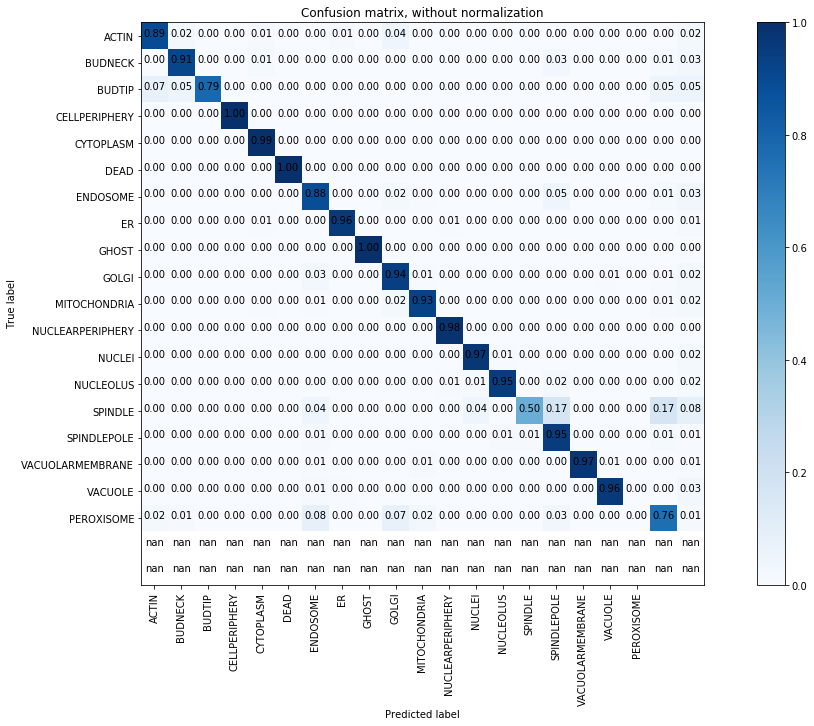

In [83]:
plt.figure(figsize=(15, 10))
plot_confusion_matrix(cf_norm, classes=idx_classes2, normalize= True,
                      title='Confusion matrix, with normalization')
plt.show()

In [84]:
def bar_chart(cm_norm, classes):
    rates = cm_norm.diagonal()
    objects = classes
    y_pos = np.arange(len(objects))
    performance = rates
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects, rotation = 90)
    plt.ylabel('Performance')
    plt.title('Prediction performance')

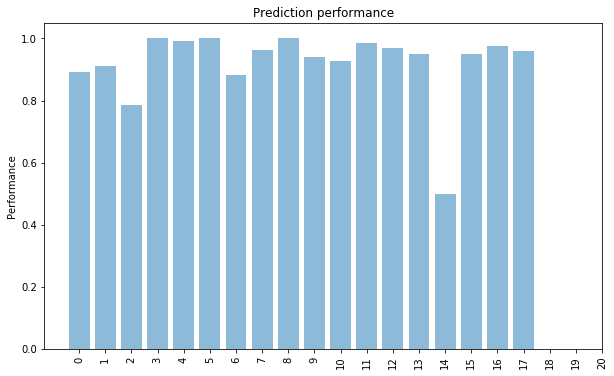

In [85]:
plt.figure(figsize=(10,6))
bar_chart(cf_norm, list(range(21)))
plt.show()